# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
assert torch.cuda.is_available()

In [3]:
import sys
sys.path.append('../')
from data import LibriSpeechDataset, label_to_sex

In [4]:
n_seconds = 3
base_sampling_rate = 16000
downsampling = 4
batchsize = 8

# Get data

In [5]:
trainset = LibriSpeechDataset('train-clean-100',base_sampling_rate*n_seconds)
testset = LibriSpeechDataset('dev-clean',base_sampling_rate*n_seconds)

Indexing data...
Finished indexing data. 27949 usable files found.
Indexing data...
Finished indexing data. 2303 usable files found.


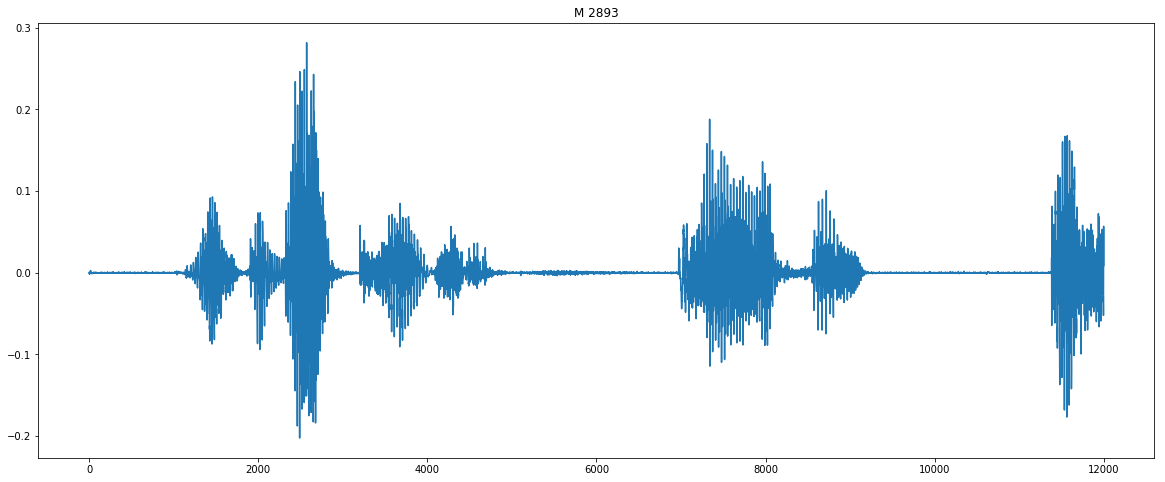

In [114]:
idx = np.random.randint(0,len(trainset))
instance, label = trainset[idx]

plt.figure(figsize=(20,8))
plt.title(label_to_sex[label]+' '+str(trainset.datasetid_to_filepath[idx]).split('/')[-3])
plt.plot(instance[::downsampling])
plt.show()

In [115]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batchsize,num_workers=4,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=batchsize,num_workers=4,shuffle=True)

In [116]:
instance[::downsampling].shape

(12000,)

In [117]:
with open('/home/oscar/Desktop/temp.flac','w') as f:
    sf.write(f,instance,16000)
with open('/home/oscar/Desktop/temp_downsampled.flac','w') as f:
    sf.write(f,instance[::downsampling],int(16000/downsampling))

### Define model

In [147]:
# class DilatedNet(nn.Module):
#     def __init__(self, filters, dilation_depth, dilation_stacks):
#         super(DilatedNet, self).__init__()
#         self.filters = filters
#         self.dilation_depth = dilation_depth
#         self.dilation_stacks = dilation_stacks

#         self.initialconv = nn.Conv1d(1 ,filters ,3 ,dilation=1 ,padding=1)
        
#         for s in range(dilation_stacks):
#             for i in range(dilation_depth):
#                 setattr(
#                     self,
#                     'dilated_conv_{}_relu_s{}'.format(3**i,s),
#                     nn.Conv1d(filters,filters,3,dilation=3**i,padding=3**i)
#                 )
                
#         self.finalconv = nn.Conv1d(filters,filters ,3 ,dilation=1 ,padding=1)
#         self.output = nn.Linear(filters ,1)
        
#     def forward(self,x):
#         x = x.cuda().double()
#         x = self.initialconv(x)
        
#         skip_connections = []
#         for s in range(self.dilation_stacks):
#             for i in range(self.dilation_depth):
#                 original_x = x
#                 x = F.relu(getattr(self,'dilated_conv_{}_relu_s{}'.format(3**i,s))(x))
#                 skip_connections.append(x)
#                 x = x + original_x
                
#         x = F.relu(self.finalconv(x))

#         x = F.max_pool1d(x, kernel_size=x.size()[2:])
#         x = x.view(-1 ,self.filters)
#         x = F.sigmoid(self.output(x))
#         return x



In [148]:
# from models import DilatedNet
# model = DilatedNet(128, 6, 1)
model = ConvNet(128, 8)
model.double()
model.cuda()

ConvNet(
  (initialconv): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (initialbn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [149]:
skip = np.random.randint(0,100)
for i, data in enumerate(testloader):
    if i != skip:
        continue
    timeseries, labels = data
    break
timeseries = timeseries.reshape((batchsize,1,base_sampling_rate*n_seconds))[:,:,::downsampling]
predicted = model(timeseries)
predicted, labels

(tensor([[ 0.4974],
         [ 0.5822],
         [ 0.4255],
         [ 0.5360],
         [ 0.5104],
         [ 0.5267],
         [ 0.5145],
         [ 0.4477]], dtype=torch.float64, device='cuda:0'),
 tensor([ 1,  1,  1,  1,  1,  1,  0,  0]))

In [48]:
def evaluate():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            timeseries, labels = data
            if timeseries.shape[0] != batchsize:
                # incomplete batch
                continue
            timeseries = timeseries.reshape((batchsize,1,base_sampling_rate*n_seconds))[:,:,::downsampling]
            predicted = model(timeseries)
            total += labels.size(0)
            correct += ((predicted > 0.5)[:,0] == labels.cuda().byte()).cpu().sum().numpy()
            
    return correct*1.0/total

In [49]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adam(model.parameters(),lr=0.0001, momentum=0.9)

In [50]:
torch.backends.cudnn.benchmark = True

In [51]:
print_every = 100
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if inputs.shape[0] != batchsize:
            # incomplete batch
            continue
                
        inputs = inputs.reshape((batchsize,1,base_sampling_rate*n_seconds))[:,:,::downsampling]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels.reshape((batchsize,1)).cuda().double())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_every == print_every - 1:    # print every 'print_every' mini-batches
            val_acc = evaluate()
#             val_acc = 0.0
            print('[%d, %5d] loss: %.3f  val_acc: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every, val_acc))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.704  val_acc: 0.643
[1,   200] loss: 0.677  val_acc: 0.692
[1,   300] loss: 0.682  val_acc: 0.679
[1,   400] loss: 0.653  val_acc: 0.705
[1,   500] loss: 0.561  val_acc: 0.701
[1,   600] loss: 0.450  val_acc: 0.863
[1,   700] loss: 0.427  val_acc: 0.885
[1,   800] loss: 0.329  val_acc: 0.826
[1,   900] loss: 0.399  val_acc: 0.865
[1,  1000] loss: 0.348  val_acc: 0.861
[1,  1100] loss: 0.348  val_acc: 0.908
[1,  1200] loss: 0.301  val_acc: 0.913
[1,  1300] loss: 0.322  val_acc: 0.892
[1,  1400] loss: 0.285  val_acc: 0.915
[1,  1500] loss: 0.302  val_acc: 0.910
[1,  1600] loss: 0.272  val_acc: 0.874
[1,  1700] loss: 0.254  val_acc: 0.918
[1,  1800] loss: 0.243  val_acc: 0.921
[1,  1900] loss: 0.243  val_acc: 0.916
[1,  2000] loss: 0.201  val_acc: 0.875
[1,  2100] loss: 0.185  val_acc: 0.926
[1,  2200] loss: 0.230  val_acc: 0.924
[1,  2300] loss: 0.176  val_acc: 0.917
[1,  2400] loss: 0.253  val_acc: 0.915
[1,  2500] loss: 0.223  val_acc: 0.933
[1,  2600] loss: 0.174  v

Process Process-145:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process Process-148:
Process Process-147:
    self.run()
Process Process-146:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/oscar/pytorch/local/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    self._target(*self._args, **self._kwargs)
    self.run()
  File "/usr/lib/python2.7/multiproces

KeyboardInterrupt: 

# Manual evaluation

In [123]:
def generate_manual_test_samples():
    skip = np.random.randint(0,len(testset)/batchsize)
    for i, data in enumerate(testloader):
        if i != skip:
            continue
        timeseries, labels = data
        break
    timeseries = timeseries.reshape((batchsize,1,base_sampling_rate*n_seconds))[:,:,::downsampling]
    predicted = model(timeseries)
    
    return timeseries, predicted, labels

In [127]:
timeseries, predicted, labels = generate_manual_test_samples()

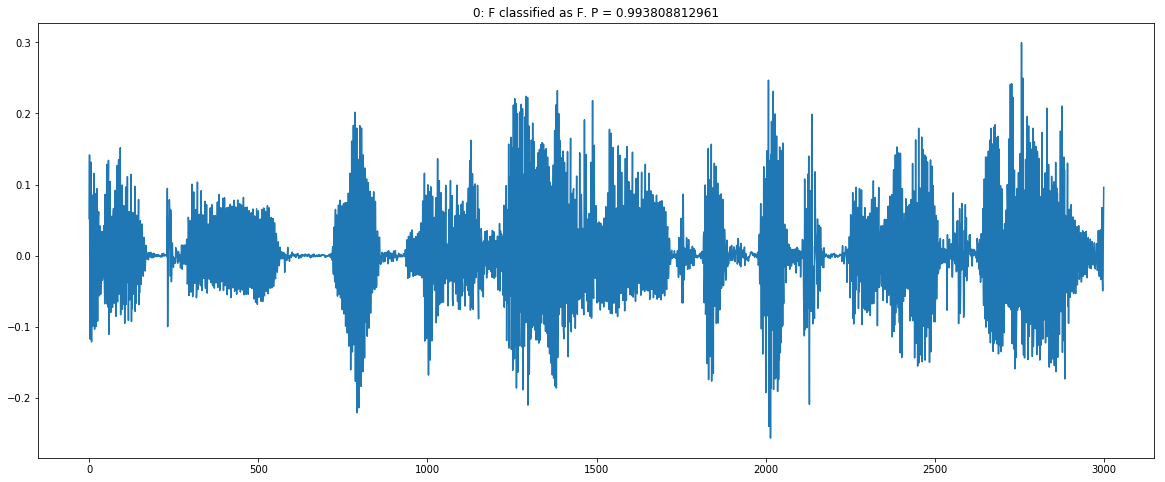

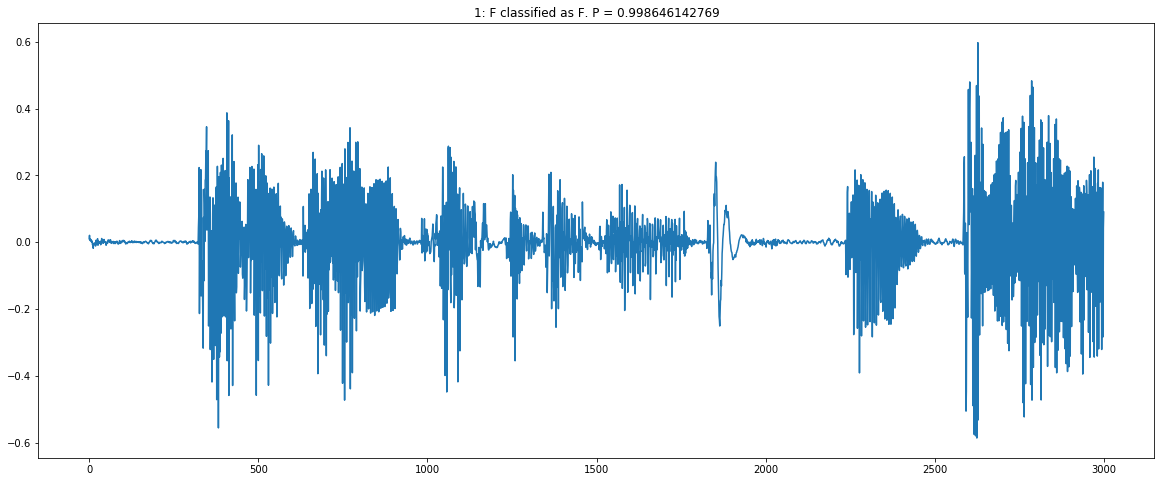

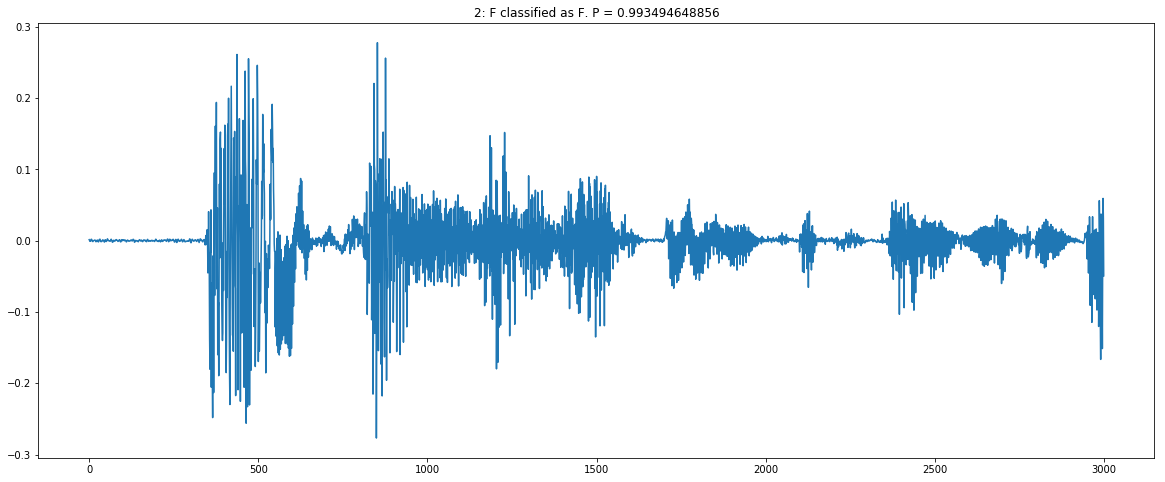

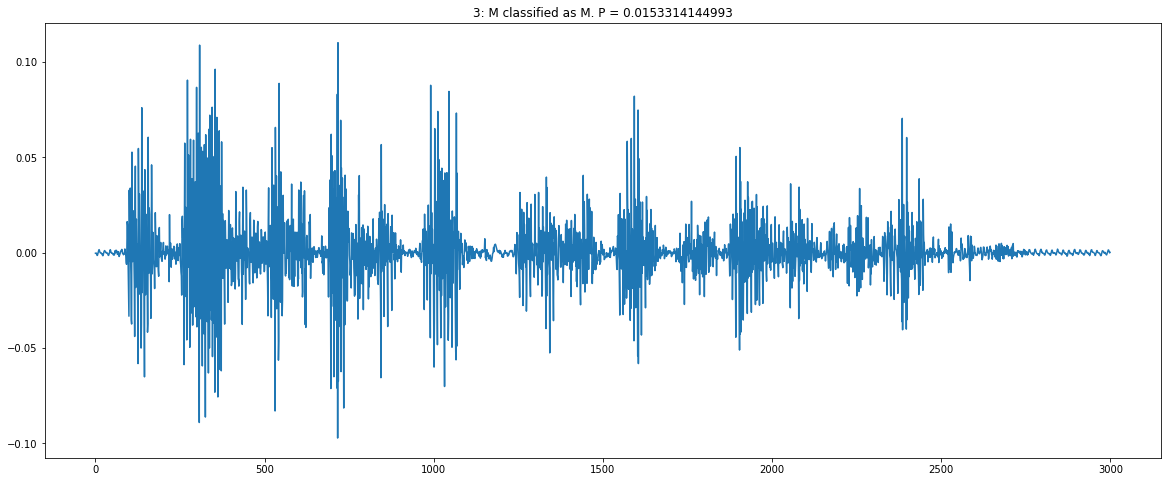

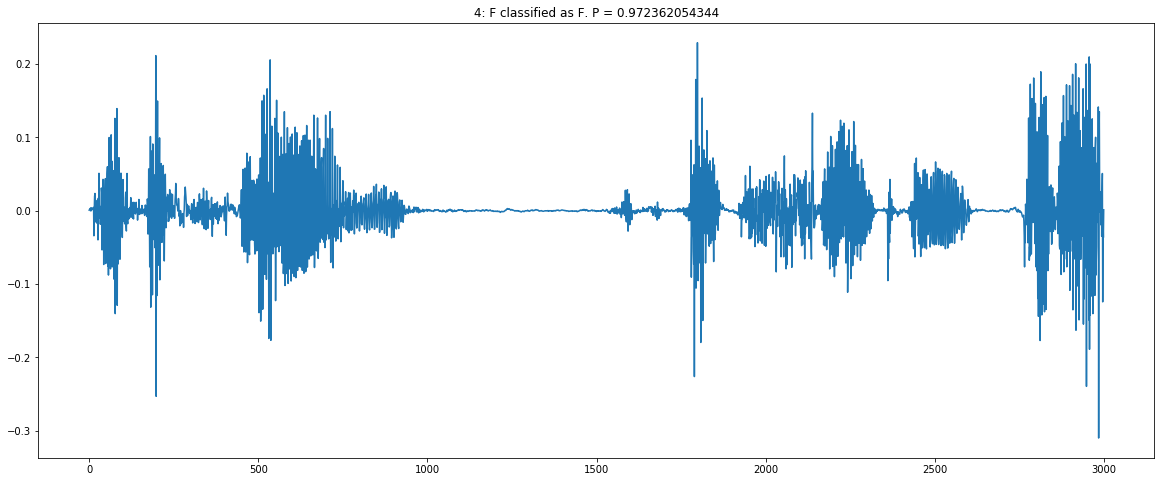

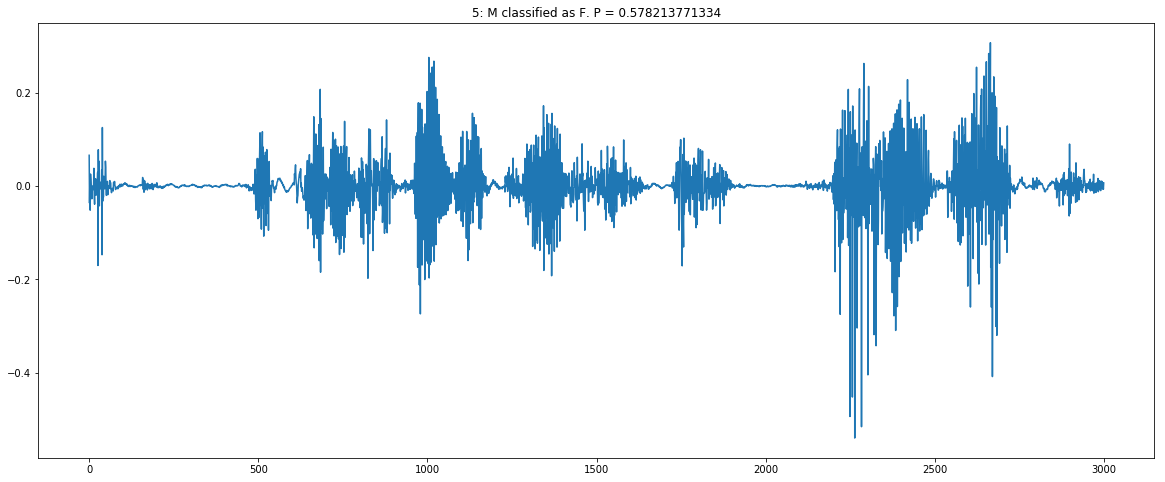

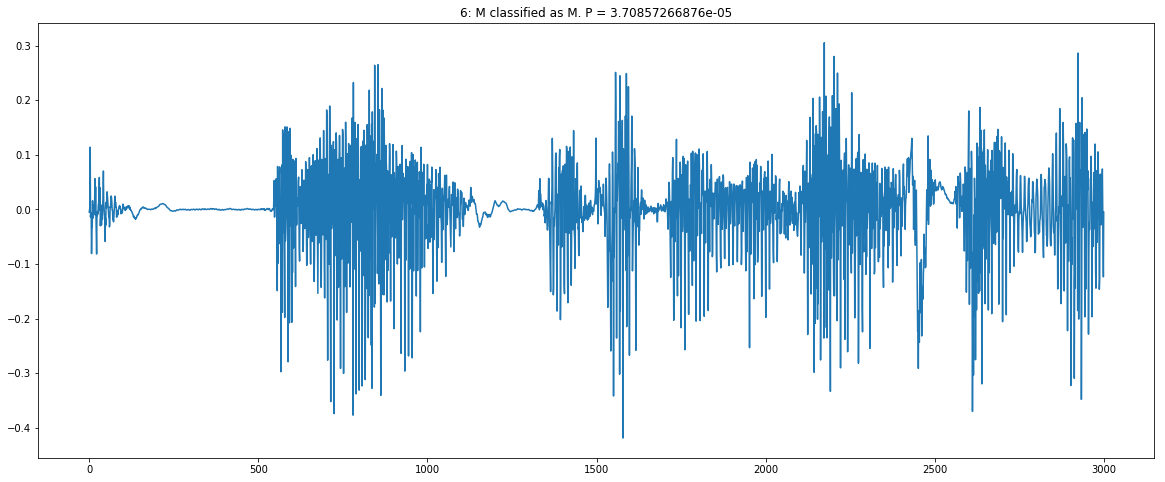

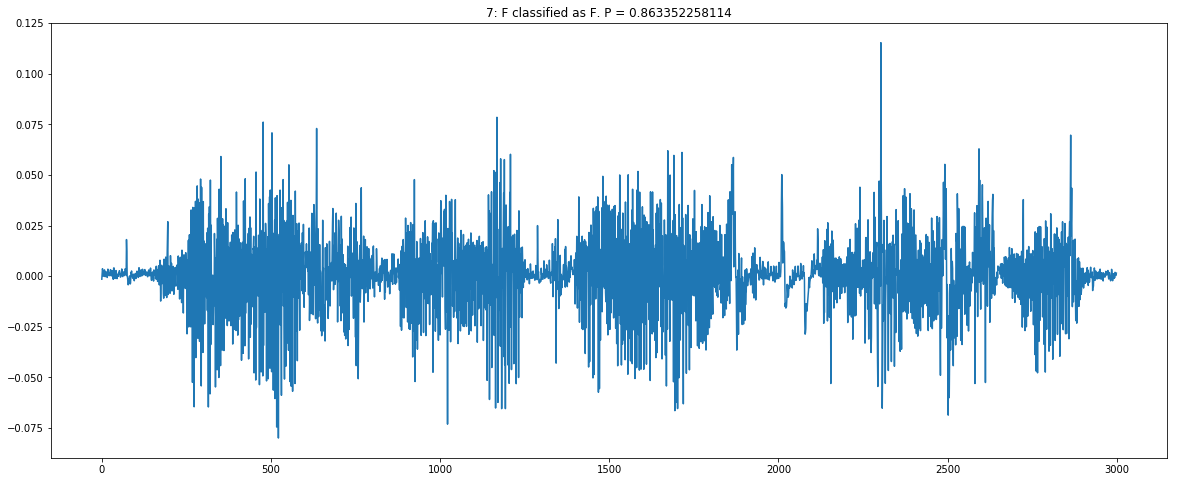

In [128]:
i = 0
for ts, pred, label in zip(timeseries, predicted, labels):
    str_label = label_to_sex[label.numpy().reshape(1,)[0]]
    str_pred = label_to_sex[int(pred[0].cpu().detach().numpy() > 0.5)]
    plt.figure(figsize=(20,8))
    plt.title('{}: {} classified as {}. P = {}'.format(i,str_label,str_pred,pred[0].cpu().detach().numpy()))
    plt.plot(ts[0].numpy()[::downsampling])
    plt.show()
    
    with open('/home/oscar/Desktop/{}.flac'.format(i),'w') as f:
            sf.write(f,ts[0].numpy(),4000)
            
    i += 1

In [120]:
# Find which speakers are misclassified the most

# Notes

In [ ]:
evaluate()

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
count_parameters(model)

345601

In [136]:
for s in range(1,4):
    for i in range(3,9):
        m = DilatedNet(128, i, s)
        print s, i, 3**i, s*(3**i), count_parameters(m)

1 3 27 27 197761
1 4 81 81 247041
1 5 243 243 296321
1 6 729 729 345601
1 7 2187 2187 394881
1 8 6561 6561 444161
2 3 27 54 345601
2 4 81 162 444161
2 5 243 486 542721
2 6 729 1458 641281
2 7 2187 4374 739841
2 8 6561 13122 838401
3 3 27 81 493441
3 4 81 243 641281
3 5 243 729 789121
3 6 729 2187 936961
3 7 2187 6561 1084801
3 8 6561 19683 1232641


In [141]:
conv = ConvNet(128, 8)

In [142]:
count_parameters(conv)

397056

In [143]:
3**8

6561